GLD-GDX:  0.509
GLD-SLV:  0.529
theta_star, mu_star, sigma_star, mle:  0.5664812602693159 18.489664592447966 0.1725641737492999 3.138999584925566
theta_star, mu_star, sigma_star, mle:  0.5999170839130994 30.02948752266828 0.14863176840088826 3.3104570580270223


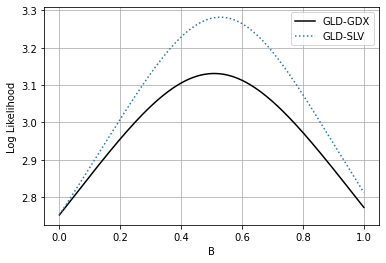

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize


# Ornstein-Uhlenbeck process is not just stationary but also normally distributed
# ou parameter : dXt = mu(theta - Xt)dt + sigma * dBt
#      - Bt : standard Brownian motion under the probability measure P
#      - mu : deterministic part & the drift of the process, mean-reversion rate
#      - sigma : control the random process 
#      - θ : long-term mean, θ ∈ R
#      - If sigma is large enough, then mu become unsignificant for the process


# Source of Mathmatical Calculation
# https://www.ubs.com/global/en/investment-bank/in-focus/research-focus/quant-answers/quant-insight-series/_jcr_content/mainpar/toplevelgrid_7262680_322968126/col1/actionbutton_3358030.1305440028.file/PS9jb250ZW50L2RhbS9pbnRlcm5ldGhvc3RpbmcvaW52ZXN0bWVudGJhbmsvZW4vZXF1aXRpZXMvcWlzLXZpcnR1YWwtZXZlbnQtZGVja3MtMjAyMC9tci10cmFkaW5nLXRhbGstdWJzLWFwcmlsLTIwMjEucGRm/mr-trading-talk-ubs-april-2021.pdf
# https://github.com/mghadam/ouparams/blob/main/src/ouparams/ouparams.py
# https://reference.wolfram.com/language/ref/OrnsteinUhlenbeckProcess.html

def get_optimal_ou_params(X, dt): 
    """
    Xx = Σ(i=1, i=n) x(i-1)
    Xy = Σ(i=1, i=n) x(i)
    Xxx = Σ(i=1, i=n) x(i-1)^2
    Xyy = Σ(i=1, i=n) x(i)^2
    Xxy = Σ(i=1, i=n) x(i) * x(i-1)
    
    something uncorrect for finding optimal mu, so we get mu by another way
    """
    n = X.size
    Xx  = np.sum(X[:-1])
    Xy  = np.sum(X[1:])
    Xxx = np.sum(X[:-1]**2)
    Xyy = np.sum(X[1:]**2)
    Xxy = np.sum(X[:-1] * X[1:])
        
    theta_star = ((Xy * Xxx) - (Xx * Xxy))/(n*(Xxx - Xxy) - ((Xx**2) - Xx * Xy)) # Mean
    mu_star = -(1 / dt) * np.log((Xxy - theta_star * Xx - theta_star * Xy + n*theta_star**2)/(Xxx - 2 * theta_star * Xx + n * theta_star**2))    
    alpha = np.exp(-mu_star * dt) # Rate
    sigma_h = np.sqrt((1/n)*(Xyy-(2*alpha*Xxy)+((alpha**2)*Xxx)-(2*theta_star*(1-alpha)*(Xy-alpha*Xx))+(n*(theta_star**2)*(1-alpha)**2)))
    sigma_star = np.sqrt((sigma_h**2)*(2*mu_star/(1-alpha**2)))  # Volatility

    return theta_star, mu_star, sigma_star


"""Inaccurate Result
def fit_ar1(ts: pd.Series, dt:float = 1/252) -> (np.array, float):
    
    # Fit AR(1) process from time series of price
    
    ts_y = ts.values[1:].reshape(-1, 1)
    ts_x = np.append(np.ones(len(ts_y)), ts.values[:-1]).reshape(2,-1).T
    
    phi = np.linalg.inv(ts_x.T @ ts_x) @ ts_x.T @ ts_y
    sigma = np.sqrt(np.sum((ts_y - ts_x @ phi) ** 2) / (len(ts_y)))
    phi = phi.reshape(-1)
    
    theta = phi[0] / (1-phi[1])
    mu = (1-phi[1]) / dt
    sigma = sigma / np.sqrt(dt)
    return theta, mu, sigma
"""

def compose_xt(s1, s2, A, B):
    alpha = A / s1[0]
    beta = B / s2[0]
    return alpha * s1 - beta * s2


# Define the OU probability density function
def f_OU(xi, xi_1, theta, mu, sigma, dt):
    sigma_tilde_squared = sigma**2 * (1 - np.exp(-2 * mu * dt)) / (2 * mu)
    exponent = -(xi - xi_1 * np.exp(-mu * dt) - theta * (1 - np.exp(-mu * dt)))**2 / (2 * sigma_tilde_squared)
    return (1 / np.sqrt(2 * np.pi * sigma_tilde_squared)) * np.exp(exponent)


# Define the average log likelihood
def avg_log_likelihood(params, Xt, dt):
    theta, mu, sigma = params
    n = len(Xt)
    sigma_tilde = np.sqrt(sigma**2 * (1 - np.exp(-2 * mu * dt)) / (2 * mu))
    
    sum_term = sum([(Xt[i] - Xt[i-1] * np.exp(-mu * dt) - theta * (1 - np.exp(-mu * dt)))**2 for i in range(1, n)])
    
    log_likelihood = (-0.5 * np.log(2 * np.pi) - np.log(sigma_tilde) - (1 / (2 * n * sigma_tilde**2)) * sum_term)
    return -log_likelihood

# Same Result
def get_average_log_likelihood(theta, mu, sigma, X, dt):
    sigma_square = sigma**2 * (1 - np.exp(-2*mu*dt)) / (2 * mu)
    sigma_tilda = np.sqrt( sigma_square )
    
    N = X.size
    
    term1 = -0.5 * np.log(2 * np.pi)
    term2 = -np.log(sigma_tilda)
    
    prefactor = -1 / (2 * N * sigma_tilda**2)
    sum_term = 0
    for i in range(1, N):
        x2 = X[i]
        x1 = X[i-1]
        
        sum_term = sum_term + (x2 - x1 * np.exp(-mu*dt) - \
                   theta * (1-np.exp(-mu*dt)))**2
    
    f = (term1 + term2 + prefactor * sum_term)
    return f

def adjust_mu_maximizing_avg_log_likelihood(xt, theta, sigma, dt=1/252):
    adjusted_initial_params = [theta, 0.1, sigma]
    bounds = [(-np.inf, np.inf), (0, np.inf), (0, np.inf)]
    # Minimize the negative log likelihood with adjusted initial guesses
    result_adjusted = minimize(avg_log_likelihood, adjusted_initial_params, args=(xt, dt), bounds=bounds, method='L-BFGS-B')

    # Extract the optimized parameters
    theta_opt_adj, mu_opt_adj, sigma_opt_adj = result_adjusted.x

    # Calculate the average log likelihood with optimized parameters
    avg_ll_opt_adj = -avg_log_likelihood([theta_opt_adj, mu_opt_adj, sigma_opt_adj], xt, dt)
    return theta_opt_adj, mu_opt_adj, sigma_opt_adj, avg_ll_opt_adj


def get_mle_table(s1, s2, dt):

    candidate_B = np.linspace(0.001, 1, 1000)
    optimal_params_table = []
    for B in candidate_B:
        X = compose_xt(s1, s2, 1, B)
        theta_star, mu_star, sigma_star = get_optimal_ou_params(X, dt)
        mle = get_average_log_likelihood(theta_star, mu_star, sigma_star, X, dt)
        optimal_params_table.append((theta_star, mu_star, sigma_star, mle, B))

    table = pd.DataFrame(optimal_params_table, columns=['theta', 'mu', 'sigma', 'mle', 'B'])
    return table


def get_B_star(table):
    return float(table.iloc[np.where(table.mle==np.max(table.mle))].B.values)


if __name__ == "__main__":
    # Same example 
    GDX = pd.read_csv('data/GDX_historical.csv', index_col=0)
    GLD = pd.read_csv('data/GLD_historical.csv', index_col=0)
    SLV = pd.read_csv('data/SLV_historical.csv', index_col=0)

    gld = GLD['Adj Close'].to_numpy()
    gdx = GDX['Close'].to_numpy()
    slv = SLV['Close'].to_numpy()

    M = 0
    gld = gld[M:M + 200]
    gdx = gdx[M:M + 200]
    slv = slv[M:M + 200]

    N = gld.size
    
    date = pd.to_datetime(GLD[:200].index)
    dt = 1.0 / ((date[-1] - date[0]).days)

    table1 = get_mle_table(gld, gdx, dt)
    table2 = get_mle_table(gld, slv, dt)

    B = np.linspace(0.001, 1, 1000)
    plt.plot(B, table1.mle, 'k', label = 'GLD-GDX')
    plt.plot(B, table2.mle, ':', label = 'GLD-SLV')
    plt.xlabel('B')
    plt.ylabel('Log Likelihood')
    plt.grid()
    plt.legend()

    B_star_gld_gdx = get_B_star(table1)
    B_star_gld_slv = get_B_star(table2)

    print('GLD-GDX: ', B_star_gld_gdx )
    print('GLD-SLV: ', B_star_gld_slv )
    
    xt = compose_xt(gld, gdx, 1, B_star_gld_gdx)
    x2t = compose_xt(gld, slv, 1, B_star_gld_slv)
    
    theta, mu, sigma = get_optimal_ou_params(xt, dt=1/252)
    theta2, mu2, sigma2 = get_optimal_ou_params(x2t, dt=1/252)
    
    theta_star, mu_star, sigma_star, mle = adjust_mu_maximizing_avg_log_likelihood(xt, theta, sigma)
    theta_star2, mu_star2, sigma_star2, mle2 = adjust_mu_maximizing_avg_log_likelihood(x2t, theta2, sigma2)
    
    print('theta_star, mu_star, sigma_star, mle: ', theta_star, mu_star, sigma_star, mle)
    print('theta_star, mu_star, sigma_star, mle: ', theta_star2, mu_star2, sigma_star2, mle2)

In [139]:
sigma_square = sigma**2 * (1 - np.exp(-2*mu*dt)) / (2 * mu)
sigma_tilda = np.sqrt( sigma_square )

In [140]:
theta_star - 1.5 * sigma_tilda

0.5515509492874362

In [141]:
theta_star + 1.5 * sigma_tilda

0.5814115712511956

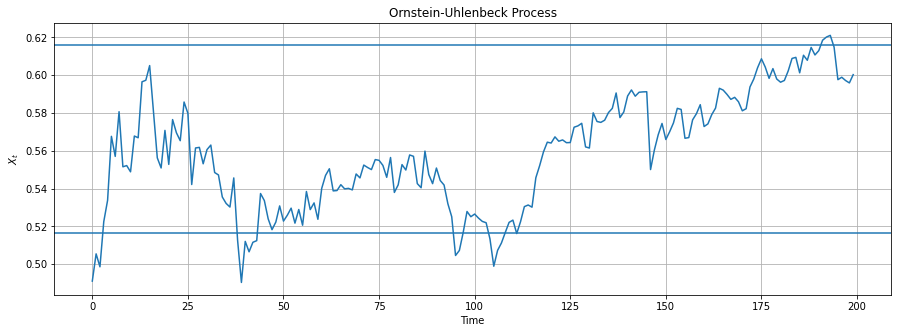

In [144]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(xt)
plt.axhline(theta_star - 5 * sigma_tilda)
plt.axhline(theta_star + 5 * sigma_tilda)
plt.xlabel('Time')
plt.ylabel('$X_t$')
plt.title('Ornstein-Uhlenbeck Process')
plt.grid(True)
plt.show()

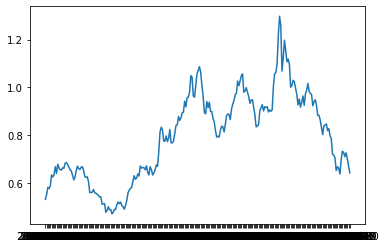

In [137]:
plt.plot(xt)

In [103]:
import math
from math import sqrt, exp, log  # exp(n) == e^n, log(n) == ln(n)
import scipy.optimize as so
import numpy as np

def __compute_log_likelihood(params, *args):
    '''
    Compute the average Log Likelihood, this function will by minimized by scipy.
    Find in (2.2) in linked paper

    returns: the average log likelihood from given parameters
    '''
    # functions passed into scipy's minimize() needs accept one parameter, a tuple of
    #   of values that we adjust to minimize the value we return.
    #   optionally, *args can be passed, which are values we don't change, but still want
    #   to use in our function (e.g. the measured heights in our sample or the value Pi)

    theta, mu, sigma = params
    X, dt = args
    n = len(X)

    sigma_tilde_squared = sigma ** 2 * (1 - exp(-2 * mu * dt)) / (2 * mu)
    summation_term = 0

    for i in range(1, len(X)):
        summation_term += (X[i] - X[i - 1] * exp(-mu * dt) - theta * (1 - exp(-mu * dt))) ** 2

    summation_term = -summation_term / (2 * n * sigma_tilde_squared)

    log_likelihood = (-log(2 * math.pi) / 2) + (-log(sqrt(sigma_tilde_squared))) + summation_term

    return -log_likelihood
    # since we want to maximize this total log likelihood, we need to minimize the
    #   negation of the this value (scipy doesn't support maximize)


def estimate_coefficients_MLE(X, dt, tol=1e-4):
    '''
    Estimates Ornstein-Uhlenbeck coefficients (θ, µ, σ) of the given array
    using the Maximum Likelihood Estimation method

    input: X - array-like time series data to be fit as an OU process
           dt - time increment (1 / days(start date - end date))
           tol - tolerance for determination (smaller tolerance means higher precision)
    returns: θ, µ, σ, Average Log Likelihood
    '''

    bounds = ((None, None), (1e-5, None), (1e-5, None))  # theta ∈ ℝ, mu > 0, sigma > 0
                                                           # we need 1e-10 b/c scipy bounds are inclusive of 0, 
                                                           # and sigma = 0 causes division by 0 error
    theta_init = np.mean(X)
    initial_guess = (theta_init, 100, 100)  # initial guesses for theta, mu, sigma
    result = so.minimize(__compute_log_likelihood, initial_guess, args=(X, dt), bounds=bounds)
    theta, mu, sigma = result.x 
    max_log_likelihood = -result.fun  # undo negation from __compute_log_likelihood
    # .x gets the optimized parameters, .fun gets the optimized value
    return theta, mu, sigma, max_log_likelihood

def compute_portfolio_values(ts_A, ts_B, alloc_B):
    '''
    Compute the portfolio values over time when holding $1 of stock A 
    and -$alloc_B of stock B
    
    input: ts_A - time-series of price data of stock A,
           ts_B - time-series of price data of stock B
    outputs: Portfolio values of holding $1 of stock A and -$alloc_B of stock B
    '''
    
    ts_A = ts_A.copy()  # defensive programming
    ts_B = ts_B.copy()
    
    ts_A = ts_A / ts_A[0]
    ts_B = ts_B / ts_B[0]
    return ts_A - alloc_B * ts_B

def arg_max_B_alloc(ts_A, ts_B, dt):
    '''
    Finds the $ allocation ratio to stock B to maximize the log likelihood
    from the fit of portfolio values to an OU process

    input: ts_A - time-series of price data of stock A,
           ts_B - time-series of price data of stock B
           dt - time increment (1 / days(start date - end date))
    returns: θ*, µ*, σ*, B*
    '''
    
    theta = mu = sigma = alloc_B = 0
    max_log_likelihood = 0

    def compute_coefficients(x):
        portfolio_values = compute_portfolio_values(ts_A, ts_B, x)
        return estimate_coefficients_MLE(portfolio_values, dt)
    
    vectorized = np.vectorize(compute_coefficients)
    linspace = np.linspace(.01, 1, 100)
    res = vectorized(linspace)
    index = res[3].argmax()
    
    return res[0][index], res[1][index], res[2][index], linspace[index]


if __name__ == "__main__":
    # Same example 
    GDX = pd.read_csv('data/GDX_historical.csv', index_col=0)
    GLD = pd.read_csv('data/GLD_historical.csv', index_col=0)
    SLV = pd.read_csv('data/SLV_historical.csv', index_col=0)

    gld = GLD['Adj Close'].to_numpy()
    gdx = GDX['Close'].to_numpy()
    slv = SLV['Close'].to_numpy()

    M = 0
    gld = gld[M:M + 200]
    gdx = gdx[M:M + 200]
    slv = slv[M:M + 200]

    N = gld.size

    date = pd.to_datetime(GLD[:200].index)
    dt = 1.0 / ((date[-1] - date[0]).days)
    
    theta, mu, sigma, b_alloc = arg_max_B_alloc(gld, gdx, dt) 
    theta2, mu2, sigma2, b_alloc2 = arg_max_B_alloc(gld, slv, dt) 

    print('GLD-GDX: ', b_alloc )
    print('GLD-SLV: ', b_alloc2 )
    
    xt = compute_portfolio_values(gld, gdx, b_alloc)
    x2t = compute_portfolio_values(gld, slv, b_alloc2)
    
    print('theta_star, mu_star, sigma_star, mle: ', theta, mu, sigma, -__compute_log_likelihood((theta, mu, sigma), xt, dt))
    print('theta_star, mu_star, sigma_star, mle: ', theta2, mu2, sigma2, -__compute_log_likelihood((theta2, mu2, sigma2), x2t, dt))

GLD-GDX:  0.5
GLD-SLV:  0.51
theta_star, mu_star, sigma_star, mle:  0.5746812846377927 21.80682668803852 0.1846027651619728 3.1394719675850493
theta_star, mu_star, sigma_star, mle:  0.6157050254317493 35.76775316571188 0.15910569175486372 3.3115397140770404


In [104]:
from math import sqrt, exp
import scipy.integrate as si
import scipy.optimize as so
import numpy as np

def Prime(f, x, theta, mu, sigma, r, h=1e-5):
    # given f, estimates f'(x) using the difference quotient formula 
    # WARNING: LOWER h VALUES CAN LEAD TO WEIRD RESULTS
    return (f(x+h, theta, mu, sigma, r) - f(x, theta, mu, sigma, r)) / h 

def Prime2(f, x, theta, mu, sigma, r, c, h=1e-5):
    # given f, estimates f'(x) using the difference quotient formula 
    # WARNING: LOWER h VALUES CAN LEAD TO WEIRD RESULTS
    return (f(x+h, theta, mu, sigma, r, c) - f(x, theta, mu, sigma, r, c)) / h 

def F(x, theta, mu, sigma, r):
    # equation 3.3
    def integrand(u):
        return u**(r/mu - 1) * exp(sqrt(2*mu / sigma**2) * (x-theta)*u - u**2/2)
    return si.quad(integrand, 0, np.inf)[0]

def G(x, theta, mu, sigma, r):
    # equation 3.4
    def integrand(u):
        return u**(r/mu - 1) * exp(sqrt(2*mu / sigma**2) * (theta-x)*u - u**2/2)
    return si.quad(integrand, 0, np.inf)[0]

def b_star(theta, mu, sigma, r, c):
    # estimates b* using equation 4.3
    # def opt_func(b):
    #     # equation 4.3 in the paper with terms moved to one side
    #     return abs(F(b, theta, mu, sigma, r) - (b-c)*Prime(F, b, theta, mu, sigma, r))
    # bounds = ((.01, .99),)
    # result = so.minimize(opt_func, .5, bounds=bounds)

    b_space = np.linspace(0.1,0.9, 801)
    def func(b):
        return F(b, theta, mu, sigma, r) - (b-c)*Prime(F, b, theta, mu, sigma, r)
    
    return so.brentq(func, 0, 1)

def V(x, theta, mu, sigma, r, c):
    # OUR SELL SIGNAL
    # equation 4.2, solution of equation posed by 2.3
    
    b_star_val = b_star(theta, mu, sigma, r, c)
    
    if x < b_star_val:
        return (b_star_val - c) * F(x, theta, mu, sigma, r) / F(b_star_val, theta, mu, sigma, r)
    else:
        return x - c

def d_star(theta, mu, sigma, r, c):
    # estimates d* using equation 4.11
  
    def func(d):
        return (G(d, theta, mu, sigma, r) * (Prime2(V, d, theta, mu, sigma, r, c) - 1)) - (Prime(G, d, theta, mu, sigma, r) * (V(d, theta, mu, sigma, r, c) - d - c))

    # finds the root between the interval [0, 1]
    return so.brentq(func, 0, 1)

In [109]:
r = c = .05
b = b_star(theta, mu, sigma, r, c)
d = d_star(theta, mu, sigma, r, c)
# b = b_star(theta_star, mu_star, sigma_star, r, c)
# d = d_star(theta_star, mu_star, sigma_star, r, c)
b, d  # our optima

/var/folders/xh/m206_s3j7dv3_xx578r1gtdr0000gn/T/ipykernel_28475/2609864267.py:20: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return si.quad(integrand, 0, np.inf)[0]
/var/folders/xh/m206_s3j7dv3_xx578r1gtdr0000gn/T/ipykernel_28475/2609864267.py:26: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return si.quad(integrand, 0, np.inf)[0]


(0.6237495157089155, 0.4741920467617012)

In [106]:
b2 = b_star(theta2, mu2, sigma2, r, c)
d2 = d_star(theta2, mu2, sigma2, r, c)
b2, d2  # our optima

/var/folders/xh/m206_s3j7dv3_xx578r1gtdr0000gn/T/ipykernel_28475/2609864267.py:20: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return si.quad(integrand, 0, np.inf)[0]
/var/folders/xh/m206_s3j7dv3_xx578r1gtdr0000gn/T/ipykernel_28475/2609864267.py:26: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return si.quad(integrand, 0, np.inf)[0]


(0.6553113430163348, 0.5374056437408832)

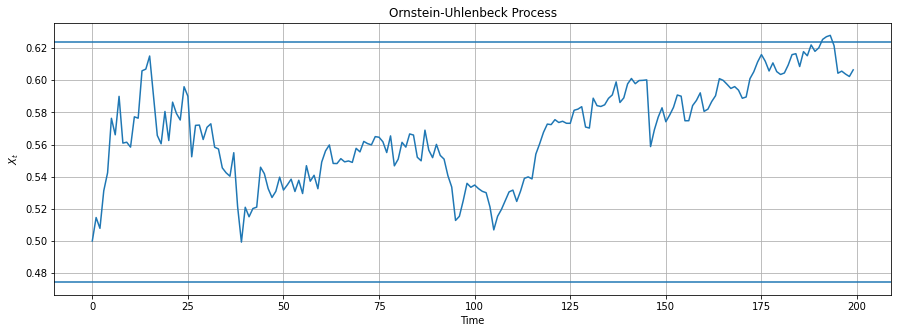

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(xt)
plt.axhline(b)
plt.axhline(d)
plt.xlabel('Time')
plt.ylabel('$X_t$')
plt.title('Ornstein-Uhlenbeck Process')
plt.grid(True)
plt.show()

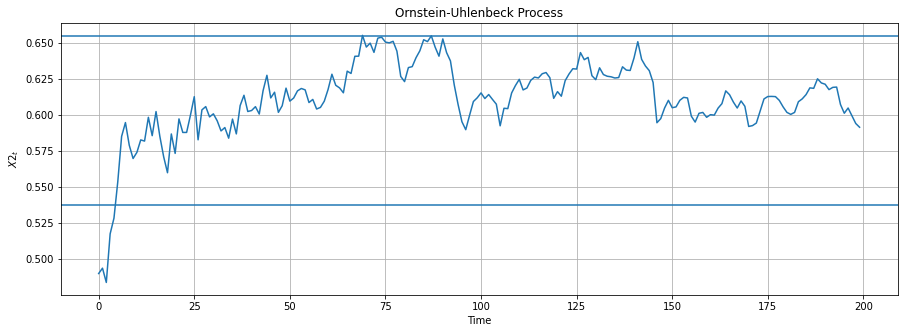

In [108]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(x2t)
plt.axhline(b2)
plt.axhline(d2)
plt.xlabel('Time')
plt.ylabel('$X2_t$')
plt.title('Ornstein-Uhlenbeck Process')
plt.grid(True)
plt.show()

In [111]:
import numpy as np
import pandas as pd

import FinanceDataReader as fdr

In [112]:
pd.read_csv('Summary.csv', index_col=0)

,asset_1,asset_2,asset_1_name,asset_2_name,A,B,l_max,theta,mu,sigma,x_0,x_T,d_star,b_star,t_first_d_star,t_first_b_star
0,A305720,A091180,"('KODEX 2차전지산업', 'technology,manufacturing')","('KODEX 자동차', 'technology,manufacturing')",1.0,-0.346734,3.244952,0.666663,6.172823,0.273016,0.653266,0.586412,0.442211,0.864322,230.0,inf
1,A305720,A228800,"('KODEX 2차전지산업', 'technology,manufacturing')","('TIGER 여행레저', 'retail')",1.0,-0.246231,3.187253,0.798653,5.163343,0.276495,0.753769,0.757815,0.562814,1.005025,inf,inf
2,A305720,A161510,"('KODEX 2차전지산업', 'technology,manufacturing')","('ARIRANG 고배당주', 'high-dividend')",1.0,-0.427136,3.185723,0.642710,4.684090,0.279961,0.572864,0.610483,0.391960,0.864322,inf,inf
3,A305720,A150460,"('KODEX 2차전지산업', 'technology,manufacturing')","('TIGER 중국소비테마', 'china,retail')",1.0,-0.467337,3.222262,0.539975,4.709891,0.268861,0.532663,0.463552,0.301508,0.763819,inf,inf
4,A305720,A228810,"('KODEX 2차전지산업', 'technology,manufacturing')","('TIGER 미디어컨텐츠', 'retail')",1.0,-0.356784,3.244978,0.665858,5.947345,0.266847,0.643216,0.649880,0.452261,0.854271,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,A280940,A250780,"('KODEX 골드선물인버스(H)', 'commodity,inverse')","('TIGER 코스닥150선물인버스', 'inverse')",1.0,0.025126,3.816008,1.067118,6.473854,0.132688,1.025126,1.074840,0.964824,1.145729,inf,278.0
1052,A280940,A295020,"('KODEX 골드선물인버스(H)', 'commodity,inverse')","('KBSTAR 국채선물10년인버스', 'inverse,bond')",1.0,-0.246231,3.819853,0.820399,4.542172,0.131439,0.753769,0.828624,0.703518,0.914573,inf,inf
1053,A280940,A217780,"('KODEX 골드선물인버스(H)', 'commodity,inverse')","('TIGER 차이나CSI300인버스(합성)', 'china,inverse')",1.0,-0.045226,3.816469,1.005124,5.939277,0.133048,0.954774,1.012244,0.894472,1.085427,inf,278.0
1054,A280940,A225030,"('KODEX 골드선물인버스(H)', 'commodity,inverse')","('TIGER 미국S&P500선물인버스(H)', 'US,inverse')",1.0,-0.015075,3.815371,1.029001,6.263750,0.133100,0.984925,1.035963,0.924623,1.105528,inf,278.0


In [113]:
etf_candidate = pd.read_csv('etf_candidate.csv', index_col=0)
"""
# get historical data and convert to csv. just enough to do once
for i in etf_candidate['code']:
    data = fdr.DataReader(i[1:],'2019')
    data.to_csv('etf_data/'+i+'.csv')
    
df=pd.DataFrame()
for i in etf_candidate['code']:
    df1 = pd.read_csv("etf_data/{}.csv".format(i), index_col=0)['Close']
    df = pd.concat([df, df1], axis=1, join='outer')
price_df.columns = etf_candidate['code']
df.to_csv('total_etf_price.csv')
"""
price_df = pd.read_csv('total_etf_price.csv', index_col=0)

In [114]:
from datetime import datetime, timedelta

given_date = datetime.strptime(price_df.index[-1], "%Y-%m-%d")
one_year_ago = given_date - timedelta(days=365)
start_date = one_year_ago.strftime("%Y-%m-%d")

sliced_df = price_df[start_date:price_df.index[-1]]

In [115]:
# make candidate of etf pair
candidate = etf_candidate['code']
etf_pairs = []
for i in range(len(candidate)):
    for j in range(len(candidate)):
        if i != j:
            etf_pairs.append((candidate[i], candidate[j]))

In [116]:
pair = etf_pairs[0]

In [117]:
pair = etf_pairs[0]

In [122]:
df_asset_1 = sliced_df[pair[0]]
df_asset_2 = sliced_df[pair[1]]

dt = 1/252
theta, mu, sigma, b_alloc = arg_max_B_alloc(df_asset_1, df_asset_2, dt)

In [123]:
xt = compute_portfolio_values(df_asset_1, df_asset_2, b_alloc)
print('theta_star, mu_star, sigma_star, mle: ', theta, mu, sigma, -__compute_log_likelihood((theta, mu, sigma), xt, dt))

theta_star, mu_star, sigma_star, mle:  0.8173049411814645 4.59819696189487 0.5108737217729337 2.0265069235096638


In [126]:
r = c = .05
b = b_star(theta, mu, sigma, r, c)
d = d_star(theta, mu, sigma, r, c)
b, d  # our optima

ValueError: f(a) and f(b) must have different signs